In [17]:
import deepxde as dde
import numpy as np

In [18]:
v = 0.01 / np.pi

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - v * dy_xx

In [19]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=160)

In [20]:
net = dde.nn.FNN([2, 20, 20, 20, 1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1.0e-3)
model.train(iterations=2500)
model.compile("L-BFGS")
model.train(iterations=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.050837 s

'compile' took 0.444675 s

Training model...

0         [1.94e-03, 1.26e-03, 5.24e-01]    [1.94e-03, 1.26e-03, 5.24e-01]    []  
1000      [3.67e-02, 1.79e-04, 5.13e-02]    [3.67e-02, 1.79e-04, 5.13e-02]    []  
2000      [3.10e-02, 5.56e-05, 4.60e-02]    [3.10e-02, 5.56e-05, 4.60e-02]    []  
2500      [2.88e-02, 1.84e-05, 4.30e-02]    [2.88e-02, 1.84e-05, 4.30e-02]    []  

Best model at step 2500:
  train loss: 7.19e-02
  test loss: 7.19e-02
  test metric: []

'train' took 11.247428 s

Compiling model...
'compile' took 0.271689 s

Training model...

Step      Train loss                        Test loss                         Test metric
2500      [2.88e-02, 1.84e-05, 4.30e-02]    [2.88e-02, 1.84e-05, 4.30e-02]    []  
3000      [2.41e-03, 1.13e-05, 8.94e-04]    [2.41e-03, 1.13e-05, 8.94e-04]        
4000      [3.73e-04, 1.51e-06, 1.78e-04]    [3.73e-04, 1.51e-06, 1.78e-04]        
5000      [1.38e-0

(<deepxde.model.LossHistory at 0x1111a08e0>,
 <deepxde.model.TrainState at 0x1111a0af0>)

In [21]:
X = geomtime.random_points(100000)
err = 1
rar_points = list()

while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    rar_points.append(X[x_id])
    data.add_anchors(X[x_id])

    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

    model.compile("adam", lr=1e-3)
    model.train(iterations=2500, callbacks=[early_stopping])

    model.compile("L-BFGS")
    loss_history, train_state = model.train(iterations=5000)

Mean residual: 4.350e-03
Adding new point: [-0.00310016  0.44462755] 

Compiling model...
'compile' took 0.298416 s



2024-03-02 18:09:30.197827: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_15/bias/Adam_3/Assign' id:8684 op device:{requested: '', assigned: ''} def:{{{node dense_15/bias/Adam_3/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_15/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_15/bias/Adam_3, dense_15/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
9021      [6.19e-04, 5.16e-08, 3.98e-06]    [2.10e-05, 5.16e-08, 3.98e-06]    []  
10000     [8.90e-05, 7.28e-08, 1.88e-05]    [7.37e-05, 7.28e-08, 1.88e-05]    []  
11000     [6.83e-05, 7.73e-08, 1.41e-05]    [5.95e-05, 7.73e-08, 1.41e-05]    []  
11521     [6.01e-05, 7.81e-08, 1.31e-05]    [5.35e-05, 7.81e-08, 1.31e-05]    []  

Best model at step 9021:
  train loss: 2.50e-05
  test loss: 2.50e-05
  test metric: []

'train' took 11.022694 s

Compiling model...
'compile' took 0.292742 s

Training model...

Step      Train loss                        Test loss                         Test metric
11521     [6.01e-05, 7.81e-08, 1.31e-05]    [5.35e-05, 7.81e-08, 1.31e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000073
  Number of iterations: 2
  Number of functions evaluations: 17

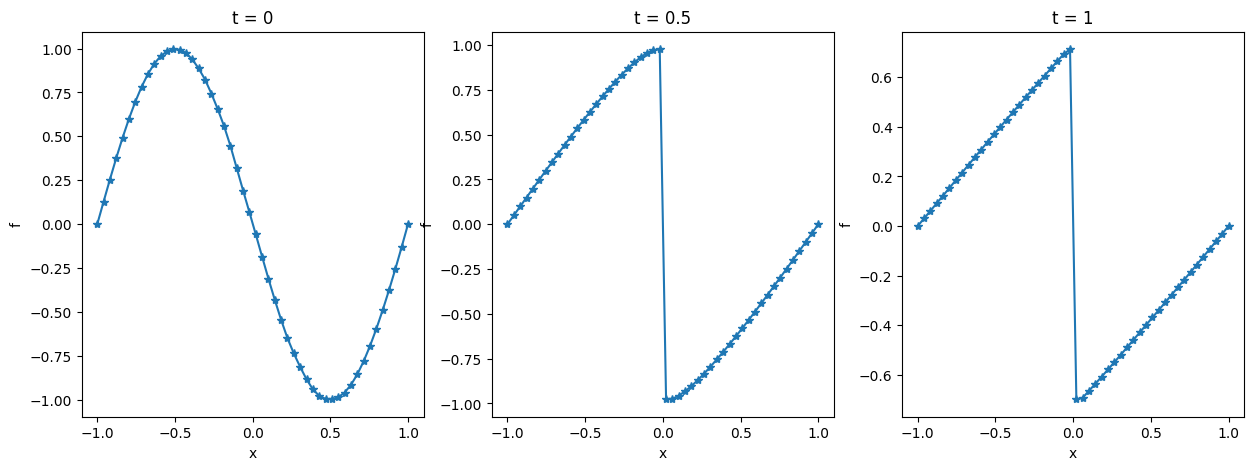

In [22]:
from matplotlib import pyplot as plt
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), squeeze=False)
axes = axes.reshape(-1)

axes[0].plot([i for i in np.linspace(-1, 1, 50)],
         [model.predict(np.array([[i, 0]]))[0] for i in np.linspace(-1, 1, 50)], marker="*")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f")
axes[0].set_title("t = 0")
axes[1].plot([i for i in np.linspace(-1, 1, 50)],
         [model.predict(np.array([[i, 0.5]]))[0] for i in np.linspace(-1, 1, 50)], marker="*")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f")
axes[1].set_title("t = 0.5")
axes[2].plot([i for i in np.linspace(-1, 1, 50)],
         [model.predict(np.array([[i, 1]]))[0] for i in np.linspace(-1, 1, 50)], marker="*")
axes[2].set_xlabel("x")
axes[2].set_ylabel("f")
axes[2].set_title("t = 1");

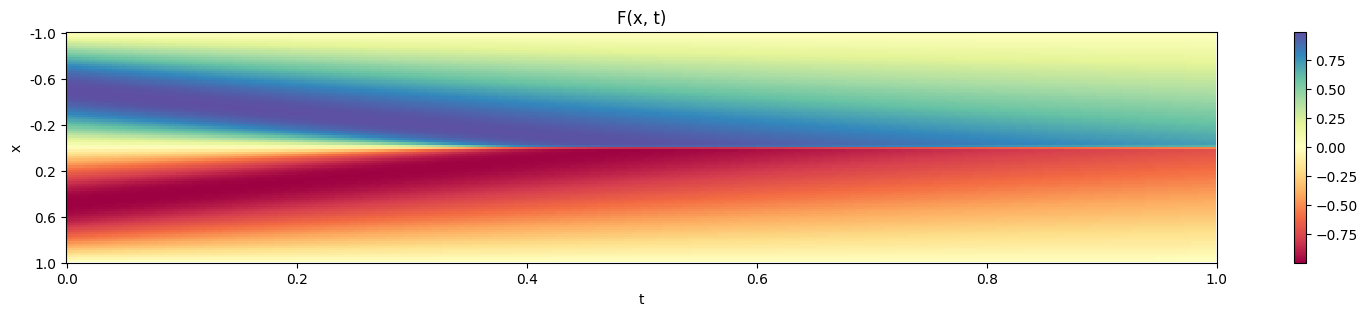

In [23]:
mat = np.array([
    [model.predict(np.array([[x, t]]))[0] for t in np.linspace(0, 1, 500)] for x in np.linspace(-1, 1, 100)
])

plt.rcParams["figure.figsize"] = (20,3)
plt.imshow(mat, cmap='Spectral', interpolation='nearest')
plt.colorbar()

locs, _ = plt.xticks()
plt.xticks(locs[1:], np.round(np.linspace(0, 1, 6), 1))

locs, _ = plt.yticks()
plt.yticks(locs[1:], np.round(np.linspace(-1, 1, 6), 1))

plt.xlabel("t")
plt.ylabel("x")
plt.title("F(x, t)");

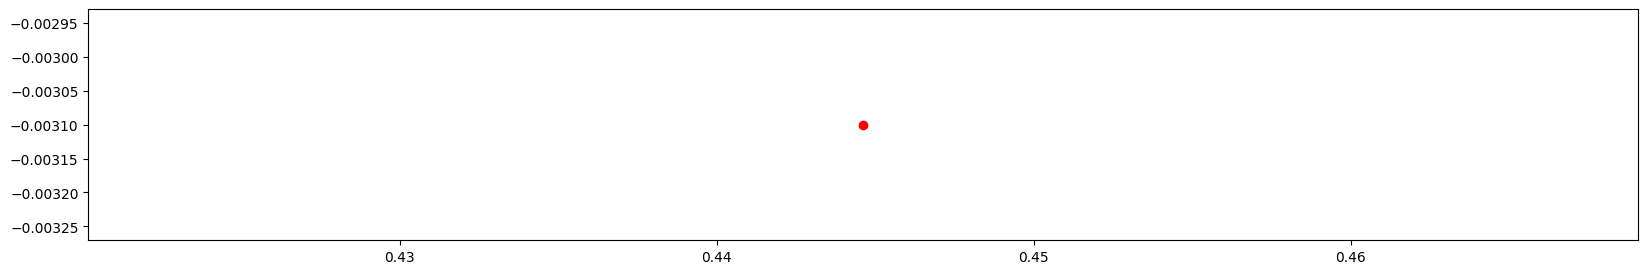

In [24]:
plt.scatter([i[1] for i in rar_points], [i[0] for i in rar_points], color="r");